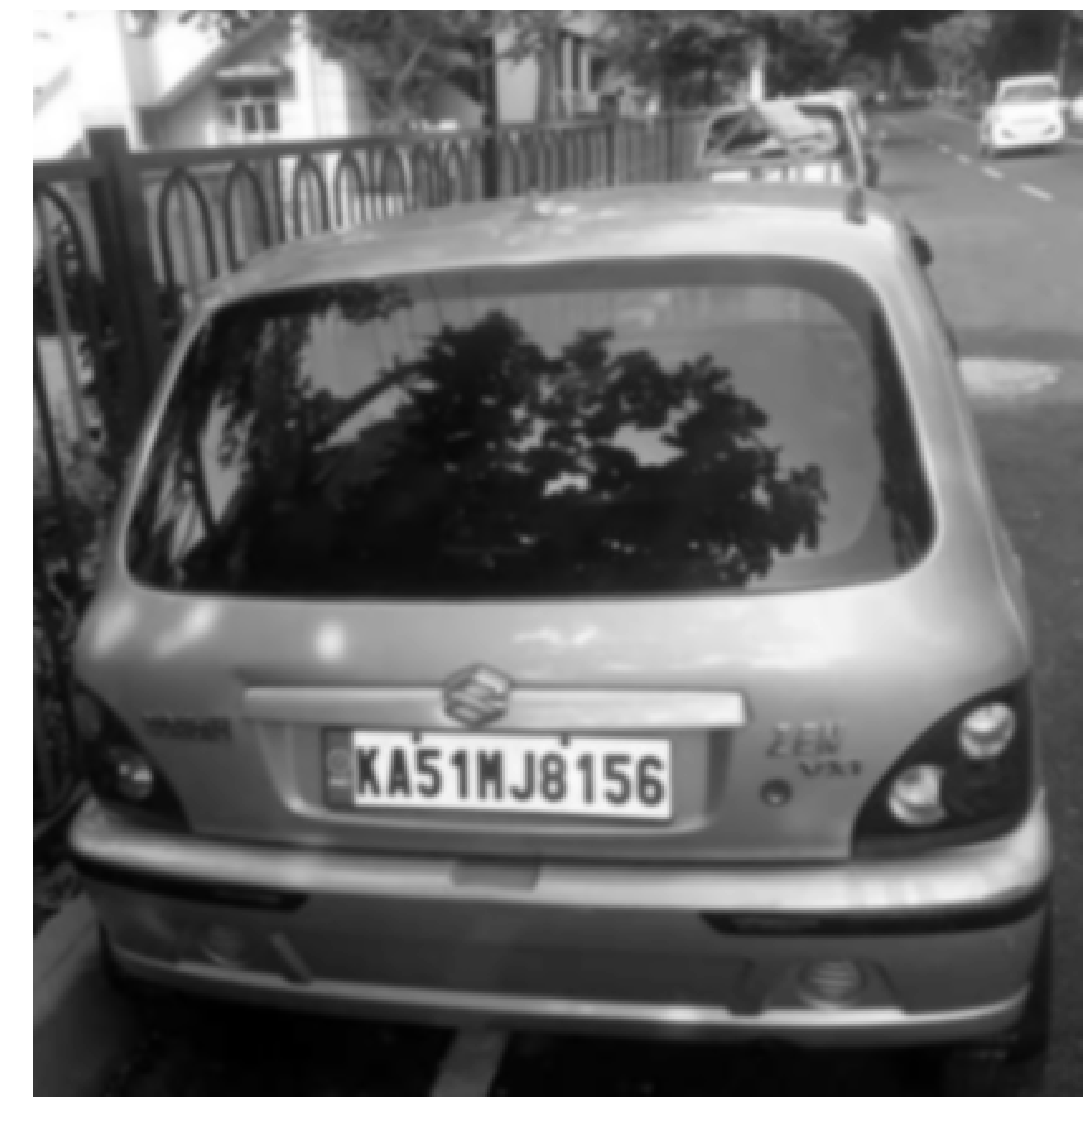

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian

# read the image and convert it to grayscale
car = imread('http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/94c5a151-24b5-493c-a900-017a4353b00c___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Tata-Tiago-Front-Number-Plates-Design.jpg')
car = imread('http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/18d2b870-7817-46da-a59a-6406c1b472c9___1033.png')
gray_img = rgb2gray(car)

#blur the image to remove any noise
blurred_gray_img = gaussian(gray_img)
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(blurred_gray_img, cmap="gray")

## Binarize the image to seperate the foreground from background.

0.427734375


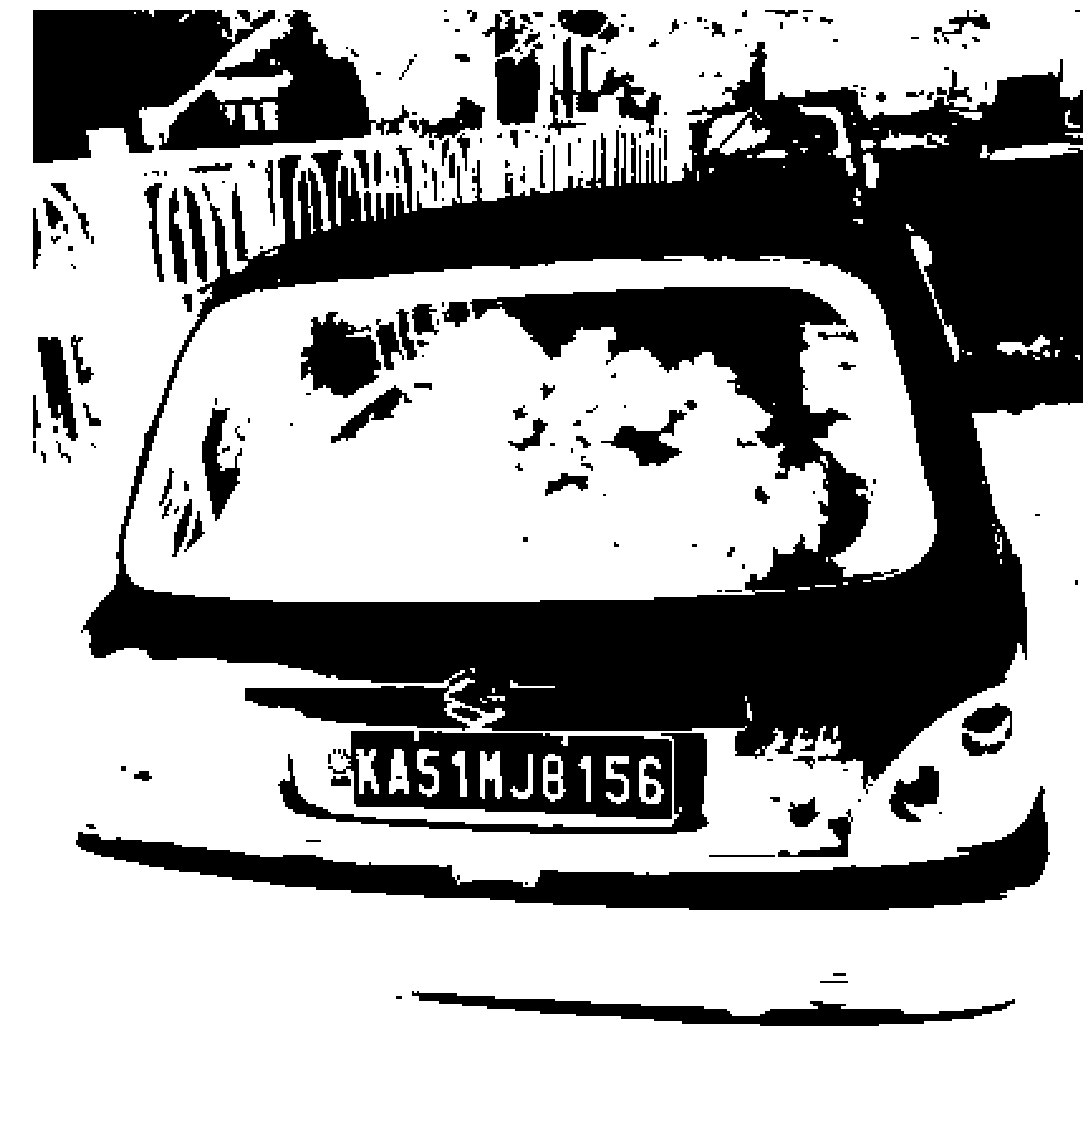

In [16]:
import matplotlib.patches as mpatches
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.spatial.distance import euclidean

thresh = threshold_otsu(gray_img)
print(thresh)
thresh = 0.46
binary = invert(gray_img > thresh)

plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(binary, cmap="gray")

## Connected component analysis of the image. connectivity set to 2 for 8 connected regions.

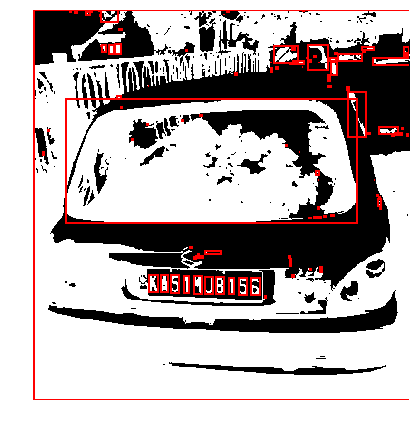

In [17]:
label_image = label(binary, connectivity=2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
ax.imshow(binary, cmap="gray")

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

## Identify regions which probably contains text.

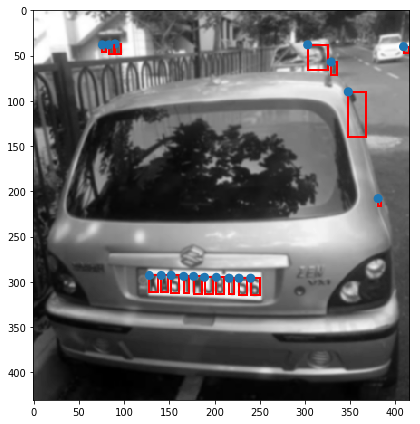

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(blurred_gray_img, cmap="gray")

text_like_regions = []
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    w = maxc - minc
    h = maxr - minr
    
    asr = w/h
    
    region_area = w*h
    
    wid,hei = blurred_gray_img.shape
    img_area = wid*hei
    
    # The aspect ratio is less than 1 to eliminate highly elongated regions
    # The size of the region should be greater than 15 pixels but smaller than 1/5th of the image
    # dimension to be considered for further processing
    if region_area > 15 and region_area < (0.2 * img_area) and asr < 1 and h > w:
        #print(w, h, i, region.area, region.bbox)
        text_like_regions.append(region)

all_points = []
for region in text_like_regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    circ = mpatches.Circle((minc, minr), radius=5)
    ax.add_patch(circ)
    all_points.append([minc, minr, maxc, maxr])
    
plt.tight_layout()
plt.show()        

/Users/muthukrishnan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':
/Users/muthukrishnan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[array([[90, 37, 97, 48],
       [76, 38, 80, 46],
       [83, 38, 89, 48],
       [76, 38, 80, 46]])]
coordinates of licence plate

[[90 37 97 48]
 [76 38 80 46]
 [83 38 89 48]
 [76 38 80 46]]


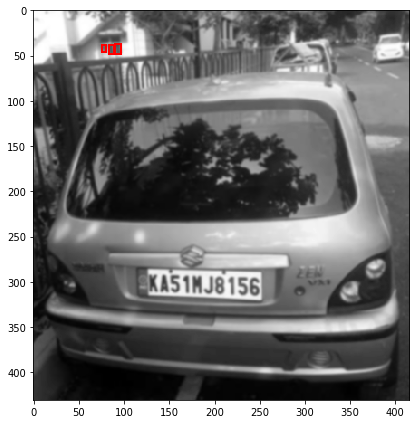

In [20]:
# find the angle between the three points A,B,C
# Angle between line BA and BC
def angle_between_three_points(pointA, pointB, pointC):
    BA = pointA - pointB
    BC = pointC - pointB

    try:
        cosine_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
        angle = np.arccos(cosine_angle)
    except:
        print("exc")
        raise Exception('invalid cosine')

    return np.degrees(angle)

all_points = np.array(all_points)

all_points = all_points[all_points[:,1].argsort()]
height, width = blurred_gray_img.shape
groups = []
for p in all_points:
    cluster = [p]
    lines_found = False
    for q in all_points:
        pmin = np.array([p[0],p[1]])
        qmin = np.array([q[0],q[1]])
        if p[1] < q[1] and euclidean(pmin,qmin) < 0.1 * width:
            # first check if q is already added, if not add.
            point_already_added = False
            for cpoints in cluster:
                if cpoints[0] == q[0] and cpoints[1] == q[1]:
                    point_already_added = True
                    break;
            if not point_already_added:
                cluster.append(q)
                
            for r in all_points:
                rmin = np.array([r[0],r[1]])
                last_cluster_point = np.array([cluster[-1][0],cluster[-1][1]])
                if q[1] < r[0] and euclidean(last_cluster_point,rmin) < 0.1 * width:
                    angle = angle_between_three_points(pmin,qmin,rmin)
                    if angle > 170 and angle < 190:
                        lines_found = True
                        cluster.append(r)
                        
    if lines_found:
        groups.append(np.array(cluster))


# plot the longest found line on the image
longest = -1
longest_index = -1
for index, cluster in enumerate(groups):
    if len(cluster) > longest:
        longest_index = index
        longest = len(cluster)

print("coordinates of licence plate\n")
print(groups[longest_index])

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(blurred_gray_img, cmap="gray")
for region in groups[longest_index]:
    minc = region[0]
    minr = region[1] 
    maxc = region[2]
    maxr = region[3]
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
plt.tight_layout()
plt.show()